# Machine Learning Lab Final Project
## Instacart Product Reorder Predictions

**Team HAM: Hannah Lyon, Andy Cheon, Meng (Marine) Lin**

**December 10, 2019**

---

### Research question: 

**How well can we predict whether a product ordered by an Instacart user had been ordered previously by that user?**

## Imports

In [118]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import compose
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from matplotlib import pyplot as pl
import matplotlib.pyplot as plt
from rfpimp import importances, plot_corr_heatmap, plot_importances

## Acquire data

Data are from six tables provided by Instacart, accessed from [Kaggle](https://www.kaggle.com/c/instacart-market-basket-analysis/data).  We join them into one data frame, `df`.

In [115]:
aisles = pd.read_csv('data/aisles.csv')
departments = pd.read_csv('data/departments.csv')
order_prior = pd.read_csv('data/order_products__prior.csv')
order_train = pd.read_csv('data/order_products__train.csv')
orders = pd.read_csv('data/orders.csv')
products = pd.read_csv('data/products.csv')

In [5]:
products = products.merge(aisles, how='left', left_on='aisle_id', right_on='aisle_id')

In [6]:
products = products.merge(departments, how='left', left_on='department_id', right_on='department_id')

In [7]:
df = pd.concat([order_prior, order_train], axis = 0)

In [8]:
df = df.merge(products, how='left', left_on='product_id', right_on='product_id')

In [9]:
df = df.merge(orders, left_on='order_id',   right_on='order_id', how = 'left')

In [ ]:
# df.to_csv('instacart.csv', index = False)  # only run if we want to save the CSV

In [ ]:
# df = pd.read_csv('instacart.csv')

In [11]:
df = df.dropna() 

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31741038 entries, 0 to 33819105
Data columns (total 15 columns):
order_id                  int64
product_id                int64
add_to_cart_order         int64
reordered                 int64
product_name              object
aisle_id                  int64
department_id             int64
aisle                     object
department                object
user_id                   int64
eval_set                  object
order_number              int64
order_dow                 int64
order_hour_of_day         int64
days_since_prior_order    float64
dtypes: float64(1), int64(10), object(4)
memory usage: 3.8+ GB


In [13]:
df.shape

(31741038, 15)

## Data processing / feature engineering

In [93]:
def data_clean(df):
    """
    Drop unnecessary columns and create three new features derived from existing features:
        1) Whether the order was placed on a weekend (1 = weekend, 0 = weekday)
        2) Whether the department carries food staples (1 = staple, 0 = not staple)
        3) Whether the product contains the label "organic" (1 = organic, 0 = not organic)
    Returns a data frame.
    """
    print("Getting dummies...")
    df = pd.get_dummies(df, columns=['department_id'], drop_first=True)
    
    # Create `weekend` feature
    print("Creating weekend flag...")
    df['weekend'] = 0
    df.loc[(df['order_dow'] == 5) | (df['order_dow'] == 6),'weekend'] = 1
    
    # Create `department_is_staple` feature
    print('Encoding dept staples...')
    staples = {
        'dairy eggs' : 1,
        'produce' : 1,
        'pantry' : 0,
        'meat seafood' : 1,
        'bakery' : 0,
        'personal care' : 0,
        'snacks' : 0,
        'breakfast' : 0,
        'beverages' : 0,
        'deli' : 0,
        'household' : 0,
        'international' : 0,
        'dry goods pasta' : 1,
        'frozen' : 0,
        'canned goods' : 0,
        'babies' : 0,
        'pets' : 0,
        'alcohol' : 0,
        'bulk' : 0,
        'missing' : 0,
        'other' : 0
    }
    df.loc[:, 'department_is_staple'] = df['department'].apply(lambda x: staples[x])
    
    # Create `product_is_organic` feature
    print('Encoding organic products...')
    df.loc[:, 'product_is_organic'] = 0
    df.loc[df.product_name.apply(lambda x: 'organic' in x.lower()), 'product_is_organic'] = 1
    
    # Drop unnecessary columns
    print('Dropping columns...')
    df.drop(['product_name', 'aisle', 'department'], axis=1, inplace=True)
    
    return df

## Subset data

Due to the size of our dataset (~37M rows), we decided to first subset the data before our stratified train-test split (see below) to have training and prediction complete in a reasonable amount of time on our local machines.  In the future, we would likely use AWS, SparkML, and/or deep learning to help solve this scalibility problem.

In [15]:
df_subset = df.sample(frac=0.01, replace=False, random_state=42)

In [16]:
df_subset.shape

(317410, 15)

## EDA

Which features might be important or correlated?

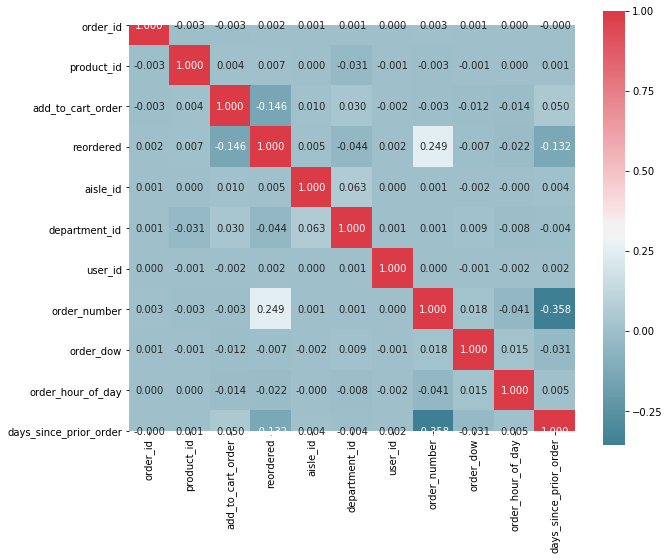

In [29]:
f, ax = pl.subplots(figsize=(10, 8))
corr = df_subset.corr()
p = sns.heatmap(corr, annot=True,mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax,fmt=".3f")
p.get_figure().savefig('heatmap.png')

## Feature engineering and train-test split

We process our data and perform **stratified train-test split** on our subsetted dataset to ensure train and test sets have the same proportion of each each class.

In [107]:
X = data_clean(df_subset.drop(['reordered', 'eval_set'], axis=1))
y = df_subset['reordered']
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
sss.get_n_splits(X, y)

Getting dummies...
Creating weekend flag...
Encoding dept staples...
Encoding organic products...
Dropping columns...


5

### EDA post-feature engineering

Perform quick EDA on our engineered featues.

Text(0.5, 1.0, 'Non Reordered Versus Reordered Products')

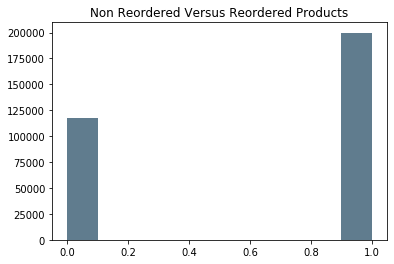

In [100]:
plt.hist(y, color='#607c8e')
plt.title('Non Reordered Versus Reordered Products')

Text(0.5, 1.0, 'Non Organic Versus Organic Products')

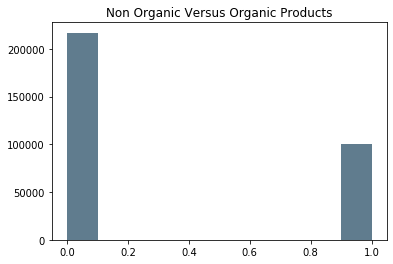

In [102]:
plt.hist(X['product_is_organic'], color='#607c8e')
plt.title('Non Organic Versus Organic Products')

Text(0.5, 1.0, 'Non Staple Versus Staple Products')

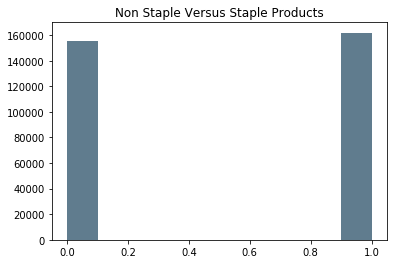

In [103]:
plt.hist(X['department_is_staple'], color='#607c8e')
plt.title('Non Staple Versus Staple Products')

### Quick check on stratified split indices

In [108]:
for train_index, test_index in sss.split(X, y):
    print(train_index)

[172729 193163 280056 ... 103326 105193  28049]
[314877  55041  90914 ...  81629 168144  67537]
[145434 144586 310128 ... 156683 180448 169843]
[233854 135606 122563 ... 177163  41070 220790]
[195338  75595  72854 ... 174883 230593 167299]


### Split into train and test sets accordingly

In [109]:
X_train = X.iloc[train_index, :]
y_train = y.iloc[train_index]
X_test = X.iloc[test_index, :]
y_test = y.iloc[test_index]

In [110]:
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

In [111]:
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')

X_train: (222187, 32)
X_test: (95223, 32)


## Pipelines

**Note**: We did not include Random Forest in the pipeline due to the volume of our data.  We decided to test out RandomForest separately.  Please see RandomSearch section for more details.

In [112]:
def make_pipelines():
    """
    Create a pipeline for each of the following algorithms:
    1. Logistic Regression
    2. k-nearest neighbors (KNN) 
    3. Naive Bayes (Guassian)
    4. Support Vector Machines (SVM)
    
    Apply StandardScaler before the algorithm if needed. 
    Use default hyperparameters.
    
    Return a list of all the pipelines.
    """ 
    numeric_features = X_train.columns
    
    numeric_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median'))])
    
    preprocessor = compose.ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features)])
    
    LR = Pipeline([('preprocessor', preprocessor),('LogisticRegression', LogisticRegression(random_state=42))])
    KNN = Pipeline([('preprocessor', preprocessor),('scaler', StandardScaler()),('KNeighborsClassifier', KNeighborsClassifier())])
    NB = Pipeline([('preprocessor', preprocessor),('GaussianNB', GaussianNB())])
    SVM = Pipeline([('preprocessor', preprocessor),('scaler', StandardScaler()), ('SVC', SVC(random_state=42))])

    pipelines=[LR,KNN,NB,SVM]
    return pipelines

In [22]:
pipelines = make_pipelines()

In [23]:
for pipe in pipelines:
    pipe.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Classification scores to compare models

The **LogisticRegression** model is our baseline and it has an F1-score of **0.49**. From the classification report, we can see that KNN performs better than our baseline, having F1 0.64. SVC also outperforms and has F1 0.67. GaussianNB appears to perform about the same as the baseline model, with F1 0.49.

In [24]:
for pipe in pipelines:
    print(pipe.steps[-1][0],'\n',classification_report(y_test, pipe.predict(X_test)))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     35265
           1       0.63      1.00      0.77     59958

    accuracy                           0.63     95223
   macro avg       0.31      0.50      0.39     95223
weighted avg       0.40      0.63      0.49     95223

KNeighborsClassifier 
               precision    recall  f1-score   support

           0       0.53      0.43      0.47     35265
           1       0.70      0.77      0.73     59958

    accuracy                           0.65     95223
   macro avg       0.61      0.60      0.60     95223
weighted avg       0.64      0.65      0.64     95223

GaussianNB 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     35265
           1       0.63      1.00      0.77     59958

    accuracy                           0.63     95223
   macro avg       0.31      0.50      0.39     95223
weighted avg     

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC 
               precision    recall  f1-score   support

           0       0.65      0.37      0.47     35265
           1       0.70      0.88      0.78     59958

    accuracy                           0.69     95223
   macro avg       0.68      0.63      0.63     95223
weighted avg       0.68      0.69      0.67     95223



#### Confusion matrix

In [36]:
for pipe in pipelines:
    print(pipe.steps[-1][0],'\n',confusion_matrix(y_test, pipe.predict(X_test)))

LogisticRegression 
 [[    0 35265]
 [    0 59958]]
KNeighborsClassifier 
 [[15169 20096]
 [13522 46436]]
GaussianNB 
 [[    0 35265]
 [    0 59958]]
SVC 
 [[12900 22365]
 [ 6917 53041]]


#### Weighted F1 score is our North Star metric.

Sort the models by weighted F1 score, descending:

In [119]:
def sort_models(pipelines, X_data, y_data, metric=f1_score, average='weighted'):
    """
    Sort the models in pipeline by weighted F1 score, descending.
    """
    scores={}
    for pipe in pipelines:
        scores[pipe.steps[-1][0]]=f1_score(y_data,pipe.predict(X_data),average=average)

    scores_sorted=dict(sorted(scores.items(), key=lambda x: x[1],reverse=True))
    return scores_sorted

In [26]:
sort_models(pipelines, X_test, y_test, metric=f1_score, average='weighted')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{'SVC': 0.6669158013436798,
 'KNeighborsClassifier': 0.637984711963618,
 'LogisticRegression': 0.48656836063123843,
 'GaussianNB': 0.48656836063123843}

## RandomForest

In addition to the models we tried in our pipeline, we fit a RandomForest model and tuned its hyperparameters.

### `RandomizedSearchCV` on RandomForest

In [25]:
def make_random_cv(estimator, param_distr, cv=3, n_iter=5):
    """
    Return RandomizedsearchCV
    """
    random_cv = RandomizedSearchCV(
                    estimator=estimator,
                    cv=cv,
                    param_distributions=param_distr,
                    n_iter=n_iter
                )
    return random_cv

In [26]:
rf_est = RandomForestClassifier(random_state=42)
param_distr = {
    'n_estimators' : [25, 50, 100, 200],
    'max_features' : [i for i in range(1, 8)],
    'min_samples_leaf' : [200, 500, 1500, 5000]
}
rf_random_cv = make_random_cv(rf_est, param_distr)

### Model evaluation

**Fit and predict using the best estimator returned from random search.**

Because there is no need to one-hot encode categorical variables for RandomForest, we drop the `department_id_<n>` dummy variables.

In [91]:
X.drop(X.columns[[i for i in range(9, 29)]], axis=1, inplace=True)

In [62]:
for train_index, test_index in sss.split(X, y):
    
    X_train = X.iloc[train_index, :]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index, :]
    y_test = y.iloc[test_index]
    
    assert X_train.shape[0] == y_train.shape[0]
    assert X_test.shape[0] == y_test.shape[0]
    
    # Fit on this X_train, y_train split
    print("Fitting...")
    rf_random_cv.fit(X_train, y_train)
    print(rf_random_cv.best_params_)
    
    # Predict using best estimator, evaluate model
    print("Predicting...")
    y_pred = rf_random_cv.best_estimator_.predict(X_test)
    print(f1_score(y_test, y_pred, average='weighted'))

Fitting...
{'n_estimators': 50, 'min_samples_leaf': 200, 'max_features': 5}
Predicting...
0.6954709678389445
Fitting...
{'n_estimators': 200, 'min_samples_leaf': 200, 'max_features': 6}
Predicting...
0.6959904354778125
Fitting...
{'n_estimators': 200, 'min_samples_leaf': 200, 'max_features': 3}
Predicting...
0.691613546302902
Fitting...
{'n_estimators': 25, 'min_samples_leaf': 200, 'max_features': 4}
Predicting...
0.6945970803491976
Fitting...
{'n_estimators': 50, 'min_samples_leaf': 500, 'max_features': 6}
Predicting...
0.6910584199380029


In [34]:
rf = RandomForestClassifier(n_estimators=200, min_samples_leaf=200, max_features=6)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=7, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [61]:
y_pred = rf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.6941767925455808

## Final model selection

Based on our RF model's weighted F1 score of 0.694, we choose **RandomForestClassifier** as our model, with the following hyparameters:
  - `n_estimators=200`
  - `min_samples_leaf=200`
  - `max_features=6`

## Visualize / interpret model output

### Plot feature importances

In [ ]:
imp = importances(rf, X_test, y_test, n_samples=-1)
plot_importances(imp)

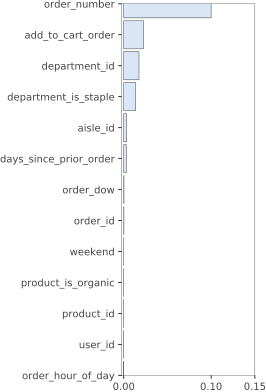

In [122]:
plot_importances(imp, label_fontsize=10, vscale=2)

**Discussion**: It appears that order number and the order in which the product is added to the cart are the most important (based on permutation importance) features, in the context of our RF model.  The `department_is_staple` feature, which we derived, is fourth most important.

## Conclusion

### Summary of methods

  - Feature engineering: created 3 new columns (weekend, staple, organic)
  - Candidate models: KNN, Naive Bayes, SVM, Logistic Regression, RF
  - Chose RF based on F1 score (0.694)

### Business impact

  - Decent prediction on whether or not a product ordered by a particular user was a reordered product
  - Provides insight into which products tend to be reordered
  - Could provide suggested products to users who open the app

### Limitations / future improvements

  - Does not take into account sequence information (user's previous orders, in chronological order)
  - Create more customer-specific and customer-product specific features
  - Could modify prediction to be user's next ordered product; try apriori algorithm (association learning)